Imports

In [290]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import h5py
import statsmodels.api as sm
from scipy.stats import skew
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

Import fMRI data

In [2]:
all_subject_arr = h5py.File('all_subject_arr.mat', 'r')
keys = all_subject_arr.keys()
data = all_subject_arr['all_subject_arr']
#all_mean_roi = np.transpose(all_mean_roi)
data = data[:]
data_ref = data[0]
data0 = all_subject_arr[data_ref[0]]
all_subject_arr[data0[:][0][0]][:][0][0]
sub_nums = np.zeros(43, dtype=int)
ROI_names = ["PCC", "SMA", "VSTR", "Kolling", "M1", "v1", "v1", "VMPFC"]
all_data = []
for i  in range(43):
    sub_data = data[i][0]
    sub_data = all_subject_arr[sub_data]
    
    #get sub_num
    sub_num = sub_data[0][0]
    sub_num = all_subject_arr[sub_num]
    sub_num = int(sub_num[0][0])
    sub_nums[i] = sub_num
    
    #get sub data values
    sub_fmri = sub_data[1][0]
    sub_fmri = all_subject_arr[sub_fmri]
    sub_fmri = sub_fmri[:][1]
    sub_ROIs = []
    for j in range(8): #extract data by ROI
        #if(i == 0 and j == 0):
            #print(all_subject_arr[sub_fmri[j]][:])
        sub_ROIs.append(all_subject_arr[sub_fmri[j]][:])
    all_data.append(sub_ROIs)
        



demean the data by blocks, RUN THIS BLOCK ONLY ONCE OR ELSE IT WILL REDUCE THE MEAN A COUPLE OF TIMES FROM THE DATA

In [3]:
all_subject_demeaned = scipy.io.loadmat('all_subject_demeaned.mat')
all_subject_demeaned = all_subject_demeaned['all_subject_demeaned']
data_demeaned = []
for i in range(43):
    sub_mean = all_subject_demeaned[0][i]
    sub_mean = sub_mean[0][1]
    block_mean = np.zeros(3)
    ROIs_demeaned = []
    for j in range(sub_mean.shape[1]):
        block_mean[j] = sub_mean[0][j][0][0]
    if(i == 0):
        print(block_mean)
    for k in range(8):
        if(i == 22): #subject 127 has no third block
            sub_data_blocks = np.reshape(all_data[i][k].T,(2,428,all_data[i][k].shape[0]))
        else:
            sub_data_blocks = np.reshape(all_data[i][k].T,(3,428,all_data[i][k].shape[0]))
        #print(sub_nums[i], i, ROI_names[k], k, sub_data_blocks.shape)
        for j in range(sub_data_blocks.shape[0]):
            sub_data_blocks[j] = sub_data_blocks[j] - block_mean[j]
        ROI_demeaned = np.reshape(sub_data_blocks, (sub_data_blocks.shape[0]*428, all_data[i][k].shape[0]))
        ROIs_demeaned.append(ROI_demeaned)
    data_demeaned.append(ROIs_demeaned)


[5314.92382812 5331.81787109 5313.82128906]


Extract MMI data

In [5]:
all_MMIs = np.zeros((43,75))
for i in range(43):
    sub_num = sub_nums[i]
    path = "./behavioral_data/" + str(sub_num) + ".xls"
    df = pd.read_excel(path)
    sub_MMI = df['MMI_In_Sample_component'].values
    sub_MMI[np.isnan(sub_MMI)] = 2
    all_MMIs[i] = sub_MMI
all_MMIs_by_blocks = np.reshape(all_MMIs, (43,3,25))
all_MMIs_by_trials = np.reshape(all_MMIs, (3225,))
all_MMIs_by_trials = np.concatenate((all_MMIs_by_trials[:1700],all_MMIs_by_trials[1725:])) #remove problematic MMIs from the third trial of subject 27

check for defaulted MMIs and remove them (value of 0 or missing)

In [6]:
zeros = []
missing = []
minus = []
for i in range(43):
    for j in range(75):
        if(all_MMIs[i][j] == 0):
            zeros.append((i,j))
        if(all_MMIs[i][j] == 2):
            missing.append((i,j))
        if(all_MMIs[i][j] < 0):
            minus.append((i,j))
zero_MMIs_trials = np.where(all_MMIs_by_trials == 0)[0]
missing_MMIs_trials = np.where(all_MMIs_by_trials == 2)[0]
minus_MMIs_trials = np.where(all_MMIs_by_trials < 0)[0]
defaulted_trials = np.concatenate((zero_MMIs_trials,missing_MMIs_trials, minus_MMIs_trials))
defaulted_trials_by_sub = missing + zeros + minus
defaulted_trials

array([1860, 1862, 1864, 1872, 1874, 1878, 1880, 1886, 1890, 1891, 1902,
       1911, 2227, 2525, 2526, 2528, 2530, 2532, 2537, 2539, 2542, 2545,
       2546, 2551, 2552, 2557, 2558, 2562, 2566, 2568, 2571, 2574, 2576,
       2579, 2581, 2582, 2583, 2586, 2587, 2589, 2590, 2593, 2595,  224,
        612,  614,  625,  626,  678, 1055, 1092, 1286, 1368, 1426, 1449,
       1555, 1639, 1869, 2159, 2173, 2228, 2314, 2341, 2396, 2454, 2519,
       2538, 3053, 3068, 3141, 1273, 2529, 2556, 2573, 2635, 2645])

RUN ONLY ONCE

In [7]:
all_MMIs_by_trials = np.delete(all_MMIs_by_trials, defaulted_trials)

Transform MMIs

In [8]:
MMIs_transformed = np.cbrt(all_MMIs_by_trials)

Get start and end indices of each trial

In [9]:
start_indices = np.zeros((43,75))
missing_trials = []
for i in range(43):
    sub_num = sub_nums[i]
    path = "./behavioral_data/" + str(sub_num) + ".xls"
    df = pd.read_excel(path)
    rt = df['RT'].values
    remaining_time = df['Remaining_time'].values
    iti = df['ITI'].values
    for j in range(1,75):
        if(np.isnan(rt[j])):
            missing_trials.append((i,j))
            rt[j] = 0
        if(j % 25 == 0):
            start_indices[i][j] = start_indices[i][j-1] + 11 + iti[j-1] + 3 #add fixation time at the beginning of each block
        else:
            start_indices[i][j] = start_indices[i][j-1] + 11 + iti[j-1]
    #print(start_indices[i], sub_num)
start_indices = start_indices + 6 #add general fMRI delay
start_indices = np.round(start_indices)
start_indices = start_indices.astype(int)


rearange data by trials and exclude v1 left (index = 5) and right (index = 6) and remove problematic trials (50-75) in subject 127
            ROI1 ROI2 ... ROI6
sub1|trial 1
     trial 2
     ...
     trial 75
sub2|
...
sub43|

In [10]:
data_by_sub_and_trials = []
data_by_trials = []
for i in range(43):
    sub_start_indices = start_indices[i]
    sub_trials = []
    for k in range(75):
        sub_trial = []
        for j in range(8):
            if(j == 5 or j == 6):
                continue
            sub_trial.append(data_demeaned[i][j][sub_start_indices[k]:sub_start_indices[k]+11])
            if(i == 22 and k >=50): #exclude the third trial of subject 127
                continue
        sub_trials.append(sub_trial)
    data_by_sub_and_trials.append(sub_trials)
for i in range(43):
    for j in range(75):
        if(i == 22 and j >=50): #exclude the third trial of subject 127
                continue
        data_by_trials.append(data_by_sub_and_trials[i][j])
        for k in range(6): #check if v1 left and right were excluded
            if(data_by_sub_and_trials[i][j][k].shape[1] == 3159):
                print("v1 left is present", i,j,k)
            if(data_by_sub_and_trials[i][j][k].shape[1] == 5049):
                print("v1 right is present", i,j,k)


remove defaulted trials (missing and zero trials and empty lists for the missing trials of the third block of subject 127)

In [11]:
data_wo_defaulted_trials = []
for i in range(3200):
    if(np.isin(i, defaulted_trials)):
        continue
    data_wo_defaulted_trials.append(data_by_trials[i])
fMRI_by_trials = data_wo_defaulted_trials

In [12]:
data_wo_defaulted_trials_by_sub = []
for i in range(43):
    sub_wo_defaulted_trials = []
    for j in range(75):
        if((i,j) in defaulted_trials_by_sub):
            continue
        sub_wo_defaulted_trials.append(data_by_sub_and_trials[i][j])
    data_wo_defaulted_trials_by_sub.append(sub_wo_defaulted_trials)
fMRI_by_sub_and_trials = data_wo_defaulted_trials_by_sub

mini-check

In [13]:
data_by_sub_and_trials[22] = data_by_sub_and_trials[22][:-25]
fMRI_by_sub_and_trials[22] = fMRI_by_sub_and_trials[22][:-25]


start extracting features: first, average and variance of each trial

In [14]:
averages = np.zeros((3124, 66))
variances = np.zeros((3124, 66))
for i in range(3124):
    trial_average = np.array([])
    trial_variance = np.array([])
    for j in range(6):
        trial_average = np.concatenate((trial_average, np.mean(fMRI_by_trials[i][j], axis=1)))
        trial_variance = np.concatenate((trial_variance,  np.var(fMRI_by_trials[i][j], axis=1)))
    averages[i] = trial_average
    variances[i] = trial_variance

calculate skewness

In [16]:
skewness = np.zeros((3124, 66))
for i in range(3124):
    trial_skew = np.array([])
    for j in range(6):
        trial_skew = np.concatenate((trial_skew, skew(fMRI_by_trials[i][j], axis=1)))
    skewness[i] = trial_skew

calculate autocorrelation of the averages of each region in every second to get a sense of the temporal advancement that is happening in every region in every trial

In [17]:
averages_by_trial_and_region = np.reshape(averages, (3124,6,11))
autocorrelations = np.zeros((3124,60))
for i in range(3124):
    trial_autocorr = np.array([])
    for j in range(6):
        curr_trial = averages_by_trial_and_region[i][j]
        curr_autocorr = sm.tsa.acf(curr_trial)[1:]
        trial_autocorr = np.concatenate((trial_autocorr, curr_autocorr))
    autocorrelations[i] = trial_autocorr


Combine all features in a dataframe (without regular correlations because it might not be a good feature)

In [201]:
row_indices = [x[0] for x in defaulted_trials_by_sub]
row_indices = Counter(row_indices)
row_indices[22] = 25
for key in row_indices:
    row_indices[key] = 75 - row_indices[key]
for i in range(43):
    if(i not in row_indices.keys()):
        row_indices[i] = 75
row_indices = dict(sorted(row_indices.items()))
row_indices
row_names = []
groups = []
for key in row_indices.keys():
    for i in range(row_indices.get(key)):
        row_names.append('trial' + str(i) + '_sub' + str(key))
        groups.append(key)
groups = np.array(groups)
groups = np.reshape(groups, (3124,1))

In [202]:
ROI_names = ["PCC", "SMA", "VSTR", "ACC", "M1", "VMPFC"]
averages_names = []
variances_names = []
skewness_names = []
autocorr_names = []

for x in ROI_names:
    for i in range(11):
        averages_names.append(x + '_average_sec' + str(i))
        variances_names.append(x + '_variance_sec' + str(i))
        skewness_names.append(x + '_skewness_sec' + str(i))
for x in ROI_names:
    for i in range(10):
        autocorr_names.append(x + '_autrocorr_lag' + str(i+1))
column_names = averages_names + variances_names + skewness_names + autocorr_names
column_names.append('MMIs transformed')
column_names.append('groups')

In [203]:
MMIs_transformed = np.reshape(MMIs_transformed, (3124,1))
combined_data = np.hstack((averages, variances, skewness, autocorrelations, MMIs_transformed, groups))
df = pd.DataFrame(combined_data, index=row_names, columns=column_names)

df.loc[groups == 35].head(10)

,PCC_average_sec0,PCC_average_sec1,PCC_average_sec2,PCC_average_sec3,PCC_average_sec4,PCC_average_sec5,PCC_average_sec6,PCC_average_sec7,PCC_average_sec8,PCC_average_sec9,...,VMPFC_autrocorr_lag3,VMPFC_autrocorr_lag4,VMPFC_autrocorr_lag5,VMPFC_autrocorr_lag6,VMPFC_autrocorr_lag7,VMPFC_autrocorr_lag8,VMPFC_autrocorr_lag9,VMPFC_autrocorr_lag10,MMIs transformed,groups
trial0_sub35,2427.269392,2449.197016,2431.841944,2461.966676,2482.057615,2458.933388,2475.013474,2476.074687,2486.531479,2477.284715,...,-0.213775,-0.124439,-0.237105,-0.155682,-0.148101,0.040569,-0.047175,0.139406,0.116004,35.0
trial1_sub35,2388.549428,2396.480397,2384.927984,2392.269412,2404.388739,2382.889047,2406.284995,2440.615534,2423.102377,2439.795029,...,-0.074161,-0.398486,-0.403244,-0.250502,-0.179627,0.043063,0.158840,-0.043090,0.091214,35.0
trial2_sub35,2424.828588,2418.122072,2425.433606,2412.485298,2409.210401,2423.421929,2431.522149,2418.939825,2409.055419,2411.827245,...,-0.413507,-0.232748,-0.085615,0.215164,-0.003230,0.066927,-0.103025,0.042487,0.016885,35.0
trial3_sub35,2381.430038,2364.265323,2380.683792,2396.744302,2391.474539,2416.142546,2437.528980,2416.328888,2429.560826,2432.957447,...,0.132034,-0.165813,-0.392908,-0.461445,-0.412328,-0.294962,-0.157906,-0.031672,0.256861,35.0
trial4_sub35,2380.184056,2428.885937,2436.619027,2427.290945,2408.354910,2395.741918,2393.965861,2398.296815,2398.925835,2386.927232,...,-0.369882,0.083075,0.483442,-0.124212,-0.307251,-0.221281,0.020401,0.191885,0.227219,35.0
trial5_sub35,2416.188579,2419.397606,2409.876668,2386.699839,2382.269725,2385.016868,2377.523042,2367.532716,2395.139226,2410.617928,...,0.048387,-0.174753,-0.240969,-0.284284,-0.388707,-0.239722,-0.093564,-0.023686,0.323954,35.0
trial6_sub35,2348.500744,2384.461534,2396.090790,2403.582542,2415.844710,2393.911248,2399.255060,2440.938365,2475.114179,2450.867001,...,-0.019242,0.128051,-0.159586,-0.115438,-0.119788,-0.126221,0.010008,0.079666,0.165961,35.0
trial7_sub35,2433.942065,2408.316583,2415.400490,2442.285870,2421.049184,2427.648909,2452.725788,2458.915012,2445.693151,2457.761761,...,0.151475,-0.079826,-0.261828,-0.117949,-0.199261,-0.298691,-0.187375,-0.045573,0.000015,35.0
trial8_sub35,2426.303432,2423.030108,2417.109003,2435.994486,2426.399145,2382.425599,2420.983598,2424.651027,2385.901416,2428.141014,...,-0.172514,-0.528704,-0.342396,-0.140667,-0.086493,0.045566,0.033807,-0.004395,0.247248,35.0
trial9_sub35,2380.512487,2425.096765,2440.966663,2429.177025,2438.341513,2451.775904,2419.769132,2415.082392,2434.236786,2402.994414,...,-0.447480,-0.511354,-0.141440,0.175734,0.102181,0.140592,0.036471,-0.078627,0.040889,35.0


Remove outliars

In [213]:
cols = df.columns.values
cols = cols[:-2]
#df[cols[0]].hist()
for i in range(len(cols)):
    colser = df[cols[i]]
    colser = (colser-np.mean(colser))/np.std(colser)
    #colser.hist()
    if(len(colser[colser>3] > 0)):
        #print(cols[i])
        #print("above 3")
        #print(colser[colser>3])
        #print("here")
        #print(colser[colser>3].index.values)
        for idx in colser[colser>3].index.values:
            if(idx in df.index):
                df = df.drop([idx])
    if(len(colser[colser<-3]) > 0):
        #print(cols[i])
        #print("below -3")
        #print(colser[colser<-3])
        for idx in colser[colser<-3].index.values:
            if(idx in df.index):
                df = df.drop([idx])
        
    

PLOT THE DATA

Y data

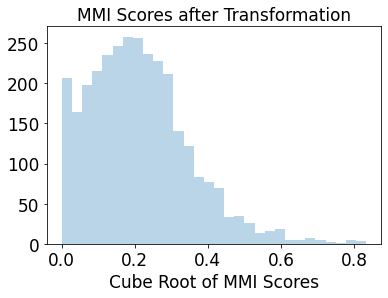

<Figure size 1440x720 with 0 Axes>

In [230]:
plt.hist(MMIs_transformed, bins=30, alpha = 0.3)
plt.xlabel("Cube Root of MMI Scores", fontsize=17)
plt.title("MMI Scores after Transformation", fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.figure(figsize=(20, 10))
plt.show()


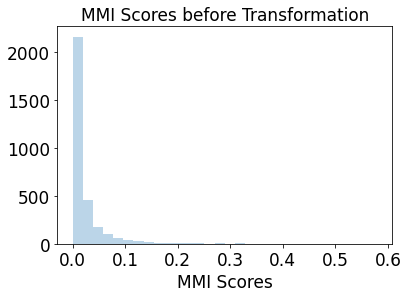

<Figure size 1440x720 with 0 Axes>

In [231]:
plt.hist(all_MMIs_by_trials, bins = 30, alpha = 0.3)
plt.xlabel("MMI Scores", fontsize=17)
plt.title("MMI Scores before Transformation", fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.figure(figsize=(20, 10))
plt.show()


Y data without outliars

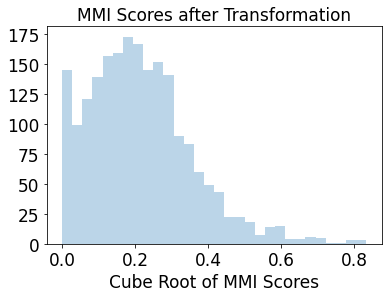

<Figure size 1440x720 with 0 Axes>

In [232]:
plt.hist(df['MMIs transformed'], bins=30, alpha = 0.3)
plt.xlabel("Cube Root of MMI Scores", fontsize=17)
plt.title("MMI Scores after Transformation", fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.figure(figsize=(20, 10))
plt.show()


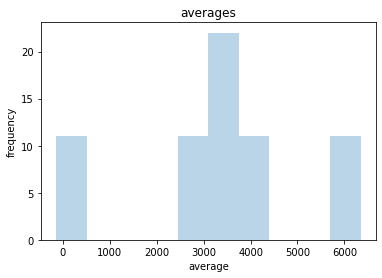

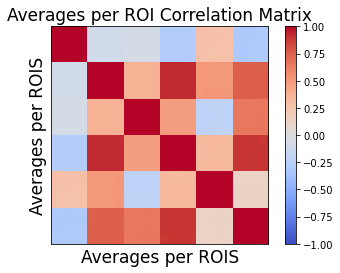

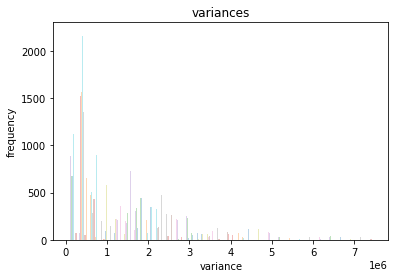

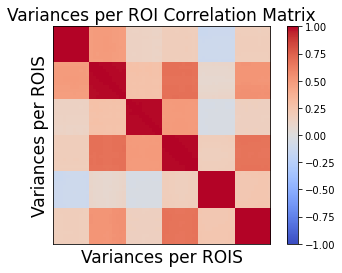

In [352]:
plt.hist(averages[3100], bins=10, alpha = 0.3)
#plt.hist(all_MMIs_by_trials, bins = 30, alpha = 0.3)
plt.xlabel('average')
plt.ylabel('frequency')
plt.title('averages')
plt.show()

correlation_matrix = np.corrcoef(df[df.columns[:66]].T)

plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Averages per ROI Correlation Matrix', fontsize=17)
plt.xticks([], fontsize=17)
plt.yticks([], fontsize=17)
plt.xlabel('Averages per ROIS', fontsize=17)
plt.ylabel('Averages per ROIS', fontsize=17)

# Display the heatmap
plt.show()

plt.hist(variances, bins=30, alpha = 0.3)
#plt.hist(all_MMIs_by_trials, bins = 30, alpha = 0.3)
plt.xlabel('variance')
plt.ylabel('frequency')
plt.title('variances')
plt.show()

correlation_matrix = np.corrcoef(df[df.columns[66:132]].T)

plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Variances per ROI Correlation Matrix', fontsize=17)
plt.xticks([], fontsize=17)
plt.yticks([], fontsize=17)
plt.xlabel('Variances per ROIS', fontsize=17)
plt.ylabel('Variances per ROIS', fontsize=17)

# Display the heatmap
plt.show()

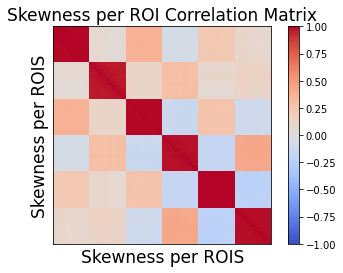

In [349]:
correlation_matrix = np.corrcoef(df[df.columns[132:198]].T)

plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Skewness per ROI Correlation Matrix', fontsize=17)
plt.xticks([], fontsize=17)
plt.yticks([], fontsize=17)
plt.xlabel('Skewness per ROIS', fontsize=17)
plt.ylabel('Skewness per ROIS', fontsize=17)

# Display the heatmap
plt.show()


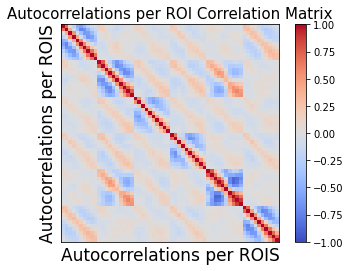

In [350]:
correlation_matrix = np.corrcoef(df[df.columns[198:258]].T)

plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Autocorrelations per ROI Correlation Matrix', fontsize=15)
plt.xticks([], fontsize=17)
plt.yticks([], fontsize=17)
plt.xlabel('Autocorrelations per ROIS', fontsize=17)
plt.ylabel('Autocorrelations per ROIS', fontsize=17)

# Display the heatmap
plt.show()


perform linear regression wiht leave group out cross validation and normalize features during the process

Linear regression Model

In [353]:
X = df[column_names[:-2]]
y = df['MMIs transformed']
groups_for_cv = df['groups']
logo = LeaveOneGroupOut()
models = []
linear_regression_mse_scores = []
linear_regression_r2_scores = []
y_tests = np.array([])
predictions = np.array([])
linear_regression_correlations = []
for train_index, test_index in logo.split(X, y, groups_for_cv):
    model = LinearRegression()
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #Normalize X_train, X_test, y_train, y_test
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    y_train = np.reshape(y_train, (y_train.shape[0],1))
    y_test = np.reshape(y_test, (y_test.shape[0],1))
    y_train = y_scaler.fit_transform(y_train)
    y_test = y_scaler.transform(y_test)
    # Fit the linear regression model on the training data
    model.fit(X_train, y_train)
    models.append(model)
    # Evaluate the linear regression model on the test data
    score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred = np.reshape(y_pred, (y_pred.shape[0]))
    linear_regression_mse_scores.append(mean_squared_error(y_test, y_pred))
    linear_regression_r2_scores.append(r2_score(y_test, y_pred))
    predictions = np.concatenate((predictions, y_pred), axis = 0)
    y_test = np.reshape(y_test, (y_test.shape[0],))
    y_tests = np.concatenate((y_tests, y_test), axis = 0)
    linear_regression_correlations.append(np.corrcoef(y_test, y_pred)[0,1])
    train_score = model.score(X_train, y_train)
    #print(f"Test score: {score:.4f}")
    #print(f"Train score: {train_score:.4f}")



results for linear regression

In [354]:
np.mean(linear_regression_mse_scores)

1.4951510513261281

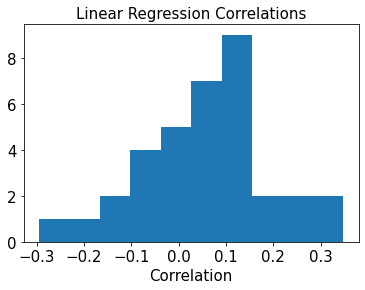

<Figure size 1440x720 with 0 Axes>

In [355]:
plt.hist(linear_regression_correlations)
plt.xlabel("Correlation", fontsize=15)
plt.title("Linear Regression Correlations", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure(figsize=(20, 10))
plt.show()

In [356]:
np.mean(linear_regression_correlations)

0.05555650940670835

check test in relation to predictions

(array([ 17.,  67., 216., 295., 459., 444., 323., 159.,  56.,  12.]),
 array([-2.01820854, -1.61400555, -1.20980256, -0.80559958, -0.40139659,
         0.00280639,  0.40700938,  0.81121237,  1.21541535,  1.61961834,
         2.02382132]),
 <BarContainer object of 10 artists>)

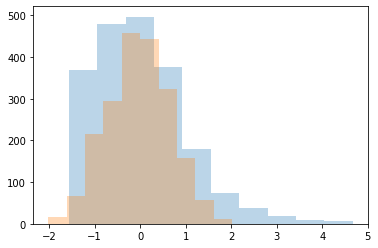

In [313]:
plt.hist(y_tests, alpha=0.3)
plt.hist(predictions, alpha=0.3)


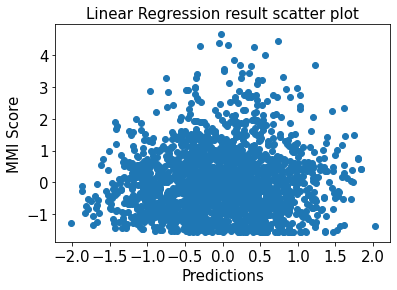

<Figure size 1440x720 with 0 Axes>

In [314]:
plt.scatter(predictions, y_tests)
plt.xlabel("Predictions", fontsize=15)
plt.ylabel("MMI Score", fontsize=15)
plt.title("Linear Regression result scatter plot", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure(figsize=(20, 10))
plt.show()

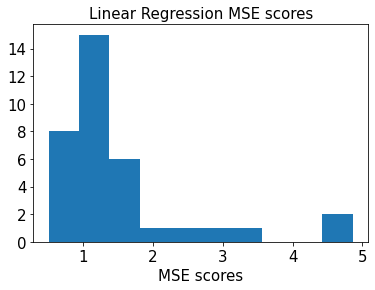

<Figure size 1440x720 with 0 Axes>

In [336]:
plt.hist(linear_regression_mse_scores)
plt.xlabel("MSE scores", fontsize=15)
plt.title("Linear Regression MSE scores", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure(figsize=(20, 10))
plt.show()

Linear Regression with ridge regularization

In [318]:
X = df[column_names[:-2]]
y = df['MMIs transformed']
groups_for_cv = df['groups']
logo = LeaveOneGroupOut()
models = []
ridge_mse_scores = []
ridge_r2_scores = []
y_tests = np.array([])
predictions = np.array([])
ridge_correlations = []
for train_index, test_index in logo.split(X, y, groups_for_cv):
    model = Ridge(alpha=0.001)
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #Normalize X_train, X_test, y_train, y_test
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    y_train = np.reshape(y_train, (y_train.shape[0],1))
    y_test = np.reshape(y_test, (y_test.shape[0],1))
    y_train = y_scaler.fit_transform(y_train)
    y_test = y_scaler.transform(y_test)
    # Fit the ridge regression model on the training data
    model.fit(X_train, y_train)
    models.append(model)
    # Evaluate the linear regression model on the test data
    score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred = np.reshape(y_pred, (y_pred.shape[0]))
    ridge_mse_scores.append(mean_squared_error(y_test, y_pred))
    ridge_r2_scores.append(r2_score(y_test, y_pred))
    predictions = np.concatenate((predictions, y_pred), axis = 0)
    y_test = np.reshape(y_test, (y_test.shape[0],))
    y_tests = np.concatenate((y_tests, y_test), axis = 0)
    ridge_correlations.append(np.corrcoef(y_test, y_pred)[0,1])
    train_score = model.score(X_train, y_train)
    #print(f"Test score: {score:.4f}")
    #print(f"Train score: {train_score:.4f}")

In [296]:
np.mean(ridge_mse_scores)

1.494865726174572

0.055543318813081645

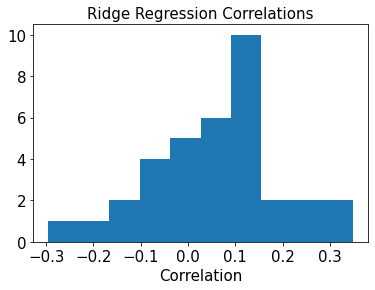

<Figure size 1440x720 with 0 Axes>

In [284]:
plt.hist(ridge_correlations)
plt.xlabel("Correlation", fontsize=15)
plt.title("Ridge Regression Correlations", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure(figsize=(20, 10))
np.mean(ridge_correlations) #mean correlation of each group

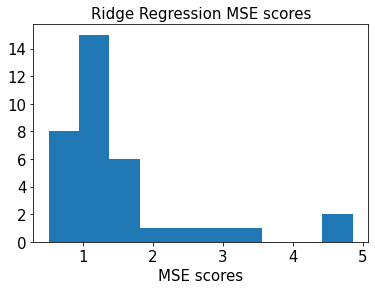

<Figure size 1440x720 with 0 Axes>

In [335]:
plt.hist(ridge_mse_scores)
plt.xlabel("MSE scores", fontsize=15)
plt.title("Ridge Regression MSE scores", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure(figsize=(20, 10))
plt.show()

XGBregressor with gird sreach CV for hyperparameter tuning

In [306]:

X = df[column_names[:-2]]
y = df['MMIs transformed']
groups_for_cv = df['groups']
logo = LeaveOneGroupOut()

models = []
xgb_mse_scores = []
xgb_r2_scores = []
y_tests = np.array([])
predictions = np.array([])
xgb_correlations = []

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.001]
}

for train_index, test_index in logo.split(X, y, groups_for_cv):
    model = XGBRegressor(random_state=42)
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Normalize X_train, X_test, y_train, y_test
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    y_train = np.reshape(y_train, (y_train.shape[0], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], 1))
    y_train = y_scaler.fit_transform(y_train)
    y_test = y_scaler.transform(y_test)
    
    #grid search and fit
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train.ravel())
    best_model = grid_search.best_estimator_
    
    # Evaluate the XGBoost model on the test data
    score = best_model.score(X_test, y_test)
    y_pred = best_model.predict(X_test)
    xgb_mse_scores.append(mean_squared_error(y_test, y_pred))
    xgb_r2_scores.append(r2_score(y_test, y_pred))
    predictions = np.concatenate((predictions, y_pred), axis=0)
    y_test = np.reshape(y_test, (y_test.shape[0],))
    y_tests = np.concatenate((y_tests, y_test), axis=0)
    xgb_correlations.append(np.corrcoef(y_test, y_pred)[0, 1])
    
    #print(f"Test score: {score:.4f}")


Test score: -0.0295
Test score: -0.1107
Test score: -0.1143
Test score: -0.2327
Test score: -0.4601
Test score: -0.7514
Test score: -0.4683
Test score: -0.4620
Test score: -0.7631
Test score: -0.0647
Test score: -0.1317
Test score: -0.1582
Test score: -0.5109
Test score: -0.0651
Test score: -0.1722
Test score: -1.4926
Test score: -0.2497
Test score: -14.8977
Test score: -1.5288
Test score: -0.1225
Test score: -0.9683
Test score: -0.2159
Test score: -0.2134
Test score: -0.2050
Test score: -0.0247
Test score: -1.3140
Test score: -9.9184
Test score: -1.2421
Test score: 0.0178
Test score: -1.3724
Test score: -0.0552
Test score: -0.3134
Test score: -0.3440
Test score: -0.1621
Test score: -2.4094


In [309]:
np.mean(xgb_mse_scores)

1.0940522920844613

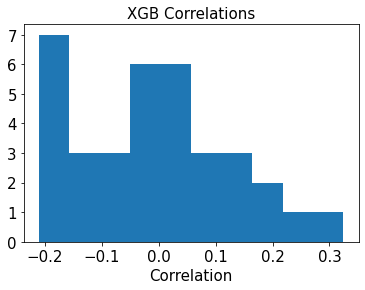

<Figure size 1440x720 with 0 Axes>

In [256]:
#print(np.corrcoef(y_tests, predictions)[0, 1]) #correlation over all the results
plt.hist(xgb_correlations)
plt.xlabel("Correlation", fontsize=15)
plt.title("XGB Correlations", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure(figsize=(20, 10))
plt.show()

In [285]:
np.mean(xgb_correlations) #mean correlation of each group


-0.0062995751331518385

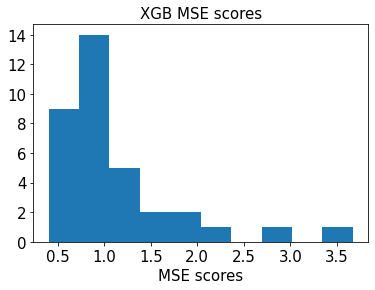

<Figure size 1440x720 with 0 Axes>

In [334]:
plt.hist(xgb_mse_scores)
plt.xlabel("MSE scores", fontsize=15)
plt.title("XGB MSE scores", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure(figsize=(20, 10))
plt.show()

SVR

In [325]:
X = df[column_names[:-2]]
y = df['MMIs transformed']
groups_for_cv = df['groups']
logo = LeaveOneGroupOut()
models = []
svr_mse_scores = []
svr_r2_scores = []
y_tests = np.array([])
predictions = np.array([])
svr_correlations = []
for train_index, test_index in logo.split(X, y, groups_for_cv):
    model = SVR(kernel='rbf', epsilon=0.05)
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #Normalize X_train, X_test, y_train, y_test
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    y_train = np.reshape(y_train, (y_train.shape[0],1))
    y_test = np.reshape(y_test, (y_test.shape[0],1))
    y_train = y_scaler.fit_transform(y_train)
    y_test = y_scaler.transform(y_test)
    # Fit the linear regression model on the training data
    model.fit(X_train, y_train)
    models.append(model)
    # Evaluate the linear regression model on the test data
    score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred = np.reshape(y_pred, (y_pred.shape[0]))
    svr_mse_scores.append(mean_squared_error(y_test, y_pred))
    svr_r2_scores.append(r2_score(y_test, y_pred))
    predictions = np.concatenate((predictions, y_pred), axis = 0)
    y_test = np.reshape(y_test, (y_test.shape[0],))
    y_tests = np.concatenate((y_tests, y_test), axis = 0)
    svr_correlations.append(np.corrcoef(y_test, y_pred)[0,1])
    train_score = model.score(X_train, y_train)
    #print(f"Test score: {score:.4f}")
    #print(f"Train score: {train_score:.4f}")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/valid

In [299]:
np.mean(svr_mse_scores)

1.0559580814337923

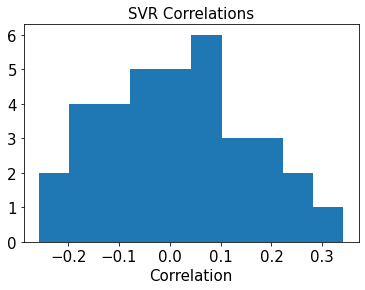

<Figure size 1440x720 with 0 Axes>

In [246]:
plt.hist(svr_correlations)
np.mean(svr_correlations) #mean correlation of each group
plt.xlabel("Correlation", fontsize=15)
plt.title("SVR Correlations", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure(figsize=(20, 10))
plt.show()

In [247]:
np.mean(svr_correlations)

0.013474645966427707

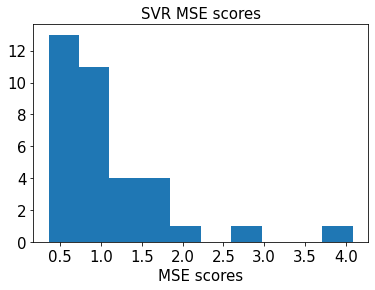

<Figure size 1440x720 with 0 Axes>

In [330]:
plt.hist(svr_mse_scores)
plt.xlabel("MSE scores", fontsize=15)
plt.title("SVR MSE scores", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure(figsize=(20, 10))
plt.show()

Random Forest with Grid Search CV for hyperparameter tuning

In [301]:
logo = LeaveOneGroupOut()
models = []
randomm_forest_mse_scores = []
randomm_forest_r2_scores = []
y_tests = np.array([])
predictions = np.array([])
random_forest_correlations = []

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

for train_index, test_index in logo.split(X, y, groups_for_cv):
    model = RandomForestRegressor(random_state=42)
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Normalize X_train, X_test, y_train, y_test
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    y_train = np.reshape(y_train, (y_train.shape[0], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], 1))
    y_train = y_scaler.fit_transform(y_train)
    y_test = y_scaler.transform(y_test)
    
    # Create GridSearchCV instance
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    # Fit the GridSearchCV on the training data
    grid_search.fit(X_train, y_train.ravel())
    
    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_
    models.append(best_model)
    # Evaluate the random forest model on the test data
    score = best_model.score(X_test, y_test)
    y_pred = best_model.predict(X_test)
    randomm_forest_mse_scores.append(mean_squared_error(y_test, y_pred))
    randomm_forest_r2_scores.append(r2_score(y_test, y_pred))
    predictions = np.concatenate((predictions, y_pred), axis=0)
    y_test = np.reshape(y_test, (y_test.shape[0],))
    y_tests = np.concatenate((y_tests, y_test), axis=0)
    random_forest_correlations.append(np.corrcoef(y_test, y_pred)[0, 1])
    
    print(f"Test score: {score:.4f}")


Test score: -0.0231
Test score: -0.0592
Test score: -0.1618
Test score: -0.5753
Test score: -0.3118
Test score: -0.8975
Test score: -0.3545
Test score: -0.6710
Test score: -0.4636
Test score: -0.0671
Test score: -0.0453
Test score: -0.1337
Test score: -0.9434
Test score: -0.0621
Test score: -0.1460
Test score: -1.3802
Test score: -0.3181
Test score: -16.9057
Test score: -1.4320
Test score: -0.1545
Test score: -1.1330
Test score: -0.4319
Test score: -0.2920
Test score: -0.4689
Test score: 0.0038
Test score: -2.3384
Test score: -17.4117
Test score: -2.1651
Test score: 0.0397
Test score: -1.0095
Test score: -0.0598
Test score: -0.3010
Test score: -0.3358
Test score: 0.0137
Test score: -1.9758


In [302]:
np.mean(randomm_forest_mse_scores)

1.175359605307237

0.03131198989806657


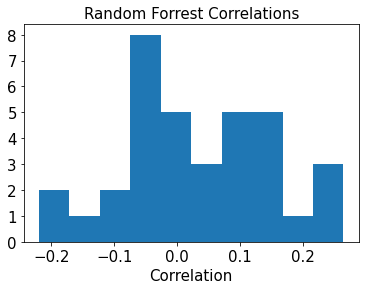

<Figure size 1440x720 with 0 Axes>

In [264]:
plt.hist(random_forest_correlations)
print(np.mean(random_forest_correlations)) #mean correlation of each group
plt.xlabel("Correlation", fontsize=15)
plt.title("Random Forrest Correlations", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure(figsize=(20, 10))
plt.show()

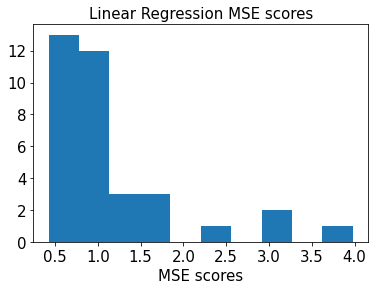

<Figure size 1440x720 with 0 Axes>

In [333]:
plt.hist(randomm_forest_mse_scores)
plt.xlabel("MSE scores", fontsize=15)
plt.title("Linear Regression MSE scores", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure(figsize=(20, 10))
plt.show()